## Capstone Check-in 2

### Chosen proposal: 

Sentiment analysis and topic modeling of forum posts regarding the Singapore government's handling of the COVID-19 outbreak in foreign worker dormitories.

### Problem statement: 

I will build a model that will conduct sentiment analysis and topic modeling on forum posts regarding the government's handling of the COVID-19 outbreak in dorms. 

Many people have expressed online their satisfaction or dissatisfaction towards how the government handled the situation. To find out the proportion of netizens who are supportive or against the government’s handling of the dorm outbreak, a model will be built to conduct sentiment analysis on online posts on the issue, to label the posts with a positive or negative sentiment. Topic modeling with then be conducted on posts from both classes to see investigate which topics are the most prevalent in the conversation surrounding this issue. 

The guiding metric of the sentiment analyser (classification) model would be the accuracy score, f1-score and specificity score (minimise false positives). The baseline score would be the score if all predictions were of the majority class (either positive or negative sentiment). As for topic modeling, the success metric would be accuracy score. 

Audience of project: Government agencies

This model could  aid the government’s awareness of the conversation surrounding its response to the covid outbreak in dorms and help it suitably craft responses to address the peoples’ concerns regarding the issue. It can be used for other types of crises in the future, including economic and social issues.

### Risks and assumptions of data 
- Data too large to manually label 
- Unable to catch and include all unique Singaporean terms into corpus 
- Data may be skewed (unbalanced class of positive and negative sentiment) 
    - could lead to problem with accuracy of predictions 
- Top words extracted may not be indicative of sentiment


### Proposed methods

#### 1. Unsupervised learning model to conduct sentiment analysis
- split data to train and test (80-20)
- word2vec tokenising - find out relation of words in dataset, generate bigrams 
- kmeans clustering for words/phrases
- assign positive or negative sentiment to words/phrases based on cluster - based on the pos, neg values of each word
- check for accuracy with a sample number of words from posts
- tfidf weighting of words for each of these posts
- predict sentiment of a sample number of posts using labeled words (use classification model) 
- preprocess all posts (tokenise, lemmatise, remove punc, stopwords (add singlish/local terms to stopwords!), lowercase, tfidf vec) 
- check accuracy of preds of sample 
- if accuracy is high - can go ahead and predict 80% of all data with sentiment words library (train data)
- check accuracy of preds for train data 
- train classification model
- check success metric on test set 
- deployment model (time permitting)
    - website to input posts from local forums, etc to check sentiment and topic

#### 2. Supervised learning model to conduct sentiment analysis (existing corpus)
- split data to train and test (80-20)
- word2vec tokenising 
- find existing corpus of labelled sentiment words (VADER, FLAIR, etc)
- augment corpus with labelled singlish/local terms 
- conduct sentiment analysis on a sample of words from posts using sentiment classifier (VADER, FLAIR, NLTK)
- manual check for accuracy
- tfidf weighting of words for each post
- predict sentiment of a sample number of posts using sentiment assigned to words/phrases
- check accuracy of preds for sample 
- if accuracy is high - can go ahead and predict 80% of all data (train data)
- check accuracy of preds for train data 
- train binary classification model 
- check success metric on test set 
- topic modeling with Latent Dirichlet Allocation
- deployment model (time permitting)


#### 2. Supervised learning model to conduct sentiment analysis (manually labeling posts)
- split data to train, test (80-20)
- word2vec tokenising of train data 
- manually label words in a small sample of posts (~10%) from train data as positive or negative 
- conduct sentiment analysis on a sample of words from posts using classification model 
- manual check for accuracy
- tfidf weighting of words for each post in train data
- incrementally train larger sample based on previous trained data until all of train set has been trained 
- manually check accuracy of predictions 
- train binary classification model with all 80% of data (train data)
- check success metric on test set 
- topic modeling with Latent Dirichlet Allocation
- deployment model (time permitting)

**Sentiment analysis model will be followed by:**

**Topic modeling with Latent Dirichlet Allocation to infer topics in corpus (posts) for both classes - investigate which are the highest occuring topics**
- data preprocessing 
- Vectorisation (tfidf)
- PCA - reduce dimensions while keeping variance to do k-means clustering 
- Clustering with PCA data  
- Dimensionality reduction with t-SNE 
- Plot tSNE clustered data with labels found by kmeans/PCA data 
- Use LDA to find most significant words in each cluster to identify each cluster’s themes 
- as data is now labelled - use supervised learning model to see how well cluster generalises 

### Data source
Scraped from reddit, hardware zone, sgtalk with search term: foreign worker dorms
- Most posts written from March onwards 

In [1]:
#import libraries 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

import regex as re

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
#import data 

reddit = pd.read_csv('./reddit_scrape.csv')
hwz = pd.read_csv('./hwz_scrape.csv')
sgtalk = pd.read_csv('./sgtalk_scrape.csv')

### Reddit data

In [3]:
display(reddit.shape)
display(reddit.info())
reddit.head()

(3622, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3622 entries, 0 to 3621
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         3622 non-null   object
 1   body          725 non-null    object
 2   comment       3622 non-null   object
 3   comment_date  3622 non-null   object
dtypes: object(4)
memory usage: 113.3+ KB


None

,title,body,comment,comment_date
0,Fake videos being spread to create trouble in ...,NaN,> # Fake videos being spread to create trouble...,2020-04-29 16:56:44
1,Fake videos being spread to create trouble in ...,NaN,Serious stuff...with serious implications for ...,2020-04-29 17:14:42
2,Fake videos being spread to create trouble in ...,NaN,Not far fetched to think that Singapore is bei...,2020-04-29 17:58:23
3,Fake videos being spread to create trouble in ...,NaN,Recently got a WA message complaining that for...,2020-04-29 17:00:19
4,Fake videos being spread to create trouble in ...,NaN,I really hope all those videos were fake or re...,2020-04-29 17:23:39


In [4]:
#convert date to pd datetime format
reddit['comment_date'] = pd.to_datetime(reddit['comment_date'])

In [5]:
#only 23 unique body posts in reddit data - drop col
len(reddit['body'].unique())

23

In [6]:
#for merged df - keep only comment and comment date 
display(reddit.isnull().sum())
display((reddit == '').sum())

title              0
body            2897
comment            0
comment_date       0
dtype: int64

title           0
body            0
comment         0
comment_date    0
dtype: int64

In [7]:
#looking for duplicate comments
display(len(reddit[reddit.duplicated(['comment'])]))
display(reddit[reddit.duplicated(['comment'])].head(10))

#most are [deleted] or [removed] - drop these cols
#rest of duplicates will be removed, first one kept 

reddit[(reddit['comment'] != '[deleted]') & (reddit['comment'] != '[removed]')]
reddit = reddit.drop_duplicates(subset='comment', keep='first')

display(reddit[reddit.duplicated(['comment'])])

128

,title,body,comment,comment_date
169,'Invest in pregnancy kits': Comments in respon...,NaN,[deleted],2020-06-04 11:31:50
212,"17 maids here have Covid-19, none infected by ...",NaN,[deleted],2020-04-23 14:43:11
236,"17 maids here have Covid-19, none infected by ...",NaN,[removed],2020-04-23 11:54:49
267,Lockdown in sg dorms... Please try to understa...,NaN,[deleted],2020-04-05 12:58:45
272,Lockdown in sg dorms... Please try to understa...,NaN,[removed],2020-04-05 13:48:22
278,Lockdown in sg dorms... Please try to understa...,NaN,[deleted],2020-04-05 21:01:05
332,Just a personal observation that opposition pa...,Nothing making any judgement here but I feel t...,[deleted],2020-07-01 01:46:50
334,Just a personal observation that opposition pa...,Nothing making any judgement here but I feel t...,[deleted],2020-07-01 01:46:11
335,Just a personal observation that opposition pa...,Nothing making any judgement here but I feel t...,[deleted],2020-07-01 01:45:19
337,Just a personal observation that opposition pa...,Nothing making any judgement here but I feel t...,[deleted],2020-07-01 03:42:55


,title,body,comment,comment_date


In [8]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3494 entries, 0 to 3621
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         3494 non-null   object        
 1   body          704 non-null    object        
 2   comment       3494 non-null   object        
 3   comment_date  3494 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 136.5+ KB


### HWZ data

In [9]:
display(hwz.shape)
display(hwz.info())
hwz.head()

(6286, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6286 entries, 0 to 6285
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   post    6177 non-null   object
 1   date    6286 non-null   object
 2   title   6286 non-null   object
dtypes: object(3)
memory usage: 147.5+ KB


None

,post,date,title
0,NaN,"13-04-2020, 11:05 AM",Life In Isolation: Inside Singapore's Foreign...
1,"Not bad, got free wifi, washing machine, washi...","13-04-2020, 04:20 PM",Life In Isolation: Inside Singapore's Foreign...
2,After sooooo many years of exploitation pappie...,"13-04-2020, 04:24 PM",Life In Isolation: Inside Singapore's Foreign...
3,there are many homeless ppl in sg...living wor...,"13-04-2020, 04:24 PM",Life In Isolation: Inside Singapore's Foreign...
4,Should listen to SDP buibui Kirsten Han and ho...,"13-04-2020, 04:26 PM",Life In Isolation: Inside Singapore's Foreign...


In [10]:
#convert date to pd datetime format
hwz['date'] = pd.to_datetime(hwz['date'])

In [11]:
#keep post and date for merged dataframe 
#check for null data 
display(hwz.isnull().sum())
display((hwz == '').sum())

#109 null values in post - fill with nopost 
hwz.fillna('nopost', inplace=True)
display(hwz.isnull().sum())

post     109
date       0
title      0
dtype: int64

post     0
date     0
title    0
dtype: int64

post     0
date     0
title    0
dtype: int64

In [12]:
#dropping duplicate rows
display(len(hwz[hwz.duplicated(['post'])]))
display(hwz[hwz.duplicated(['post'])].head(10))

hwz = hwz.drop_duplicates(subset='post', keep='first')

display(hwz[hwz.duplicated(['post'])])

201

,post,date,title
65,nopost,2020-12-04 17:20:00,Life In Isolation: Inside Singapore's Foreign...
281,nopost,2020-04-05 13:02:00,GPGT - Covid-19-free foreign workers enjoy se...
294,nopost,2020-04-05 13:12:00,GPGT - Covid-19-free foreign workers enjoy se...
297,nopost,2020-04-05 13:14:00,GPGT - Covid-19-free foreign workers enjoy se...
362,Whose fault???,2020-04-17 10:43:00,"Pappy scold sinkies for the Covid spread, tur..."
424,She should offer herself to comfort all the ba...,2020-04-14 20:01:00,All foreign worker dormitories to be 'effecti...
499,Really is considered as lockdown liao. Even es...,2020-04-14 21:52:00,All foreign worker dormitories to be 'effecti...
598,nopost,2020-04-21 18:00:00,All foreign worker dormitories to be 'effecti...
631,Should be interesting when the 2nd wave breaks...,2020-11-05 00:21:00,"S'pore looking to return foreign workers, inc..."
633,nopost,2020-11-05 00:25:00,"S'pore looking to return foreign workers, inc..."


,post,date,title


In [13]:
hwz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6085 entries, 0 to 6285
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   post    6085 non-null   object        
 1   date    6085 non-null   datetime64[ns]
 2   title   6085 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 190.2+ KB


### Sgtalk data

In [14]:
display(sgtalk.shape)
sgtalk.head()

(727, 3)

,post,date,title
0,SINGAPORE - The Government will be footing the...,11-5-2020 9:10 PM,Govt to absorb additional operational costs fo...
1,Wow! Ownself pay ownself with taxpayers $$$!,11-5-2020 9:15 PM,Govt to absorb additional operational costs fo...
2,Our govt like damm rich and spend money like d...,11-5-2020 9:16 PM,Govt to absorb additional operational costs fo...
3,Our govt like damm rich and spend money like d...,11-5-2020 9:19 PM,Govt to absorb additional operational costs fo...
4,Since when any govt have money but from taxpayers,11-5-2020 9:24 PM,Govt to absorb additional operational costs fo...


In [15]:
#convert date to pd datetime format
sgtalk['date'] = pd.to_datetime(sgtalk['date'])

In [16]:
#keep post and date for merged dataframe 
#check for null data 
display(sgtalk.isnull().sum())
display((sgtalk == '').sum())

#18 null values in post - fill with nopost 
sgtalk.fillna('nopost', inplace=True)
display(sgtalk.isnull().sum())

post     18
date      0
title     0
dtype: int64

post     0
date     0
title    0
dtype: int64

post     0
date     0
title    0
dtype: int64

In [17]:
#dropping duplicate rows
display(len(sgtalk[sgtalk.duplicated(['post'])]))
display(sgtalk[sgtalk.duplicated(['post'])].head(10))

sgtalk = sgtalk.drop_duplicates(subset='post', keep='first')

display(sgtalk[sgtalk.duplicated(['post'])])

31

,post,date,title
34,nopost,2020-11-05 22:29:00,Govt to absorb additional operational costs fo...
88,nopost,2020-05-16 12:10:00,Govt to absorb additional operational costs fo...
89,nopost,2020-05-16 12:11:00,Govt to absorb additional operational costs fo...
125,I’m also landlord. If my tenants infected with...,2020-05-13 21:10:00,Netizens praise WP’s Png Eng Huat for asking i...
200,Aiyah trust me.. she will still be minister af...,2020-06-06 11:28:00,Ministers Tharman and Teo Chee Hean brought in...
260,I think Pap need 1000 ministers. Population to...,2020-07-06 11:36:00,Ministers Tharman and Teo Chee Hean brought in...
292,"If we were to analyse it, the dormitories are ...",2020-04-13 10:29:00,Dormitory operators should be fined for endang...
342,nopost,2020-04-29 17:07:00,Dormitory operators should be fined for endang...
354,nopost,2020-05-05 11:01:00,Dormitory operators should be fined for endang...
364,talk what cock??? we want leader to have fores...,2020-09-04 22:02:00,"Lawrence Wong: Unfortunately, we do not have t..."


,post,date,title


In [18]:
sgtalk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 696 entries, 0 to 726
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   post    696 non-null    object        
 1   date    696 non-null    datetime64[ns]
 2   title   696 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 21.8+ KB


### Merged dataframe

In [19]:
reddit_merge = reddit[['comment', 'comment_date']]
reddit_merge.rename(columns = {'comment': 'post', 'comment_date':'date'}, inplace=True)
reddit_merge['source'] = 'reddit'
display(reddit_merge.head(2))

hwz_merge = hwz[['post', 'date']]
hwz_merge['source'] = 'hardwarezone'
display(hwz_merge.head(2))

sgtalk_merge = sgtalk[['post', 'date']]
sgtalk_merge['source'] = 'sgtalk'
display(sgtalk_merge.head(2))

/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,post,date,source
0,> # Fake videos being spread to create trouble...,2020-04-29 16:56:44,reddit
1,Serious stuff...with serious implications for ...,2020-04-29 17:14:42,reddit


,post,date,source
0,nopost,2020-04-13 11:05:00,hardwarezone
1,"Not bad, got free wifi, washing machine, washi...",2020-04-13 16:20:00,hardwarezone


,post,date,source
0,SINGAPORE - The Government will be footing the...,2020-11-05 21:10:00,sgtalk
1,Wow! Ownself pay ownself with taxpayers $$$!,2020-11-05 21:15:00,sgtalk


In [20]:
#merge all 3 dataframes
all_posts = pd.concat([reddit_merge, hwz_merge, sgtalk_merge], axis=0)
display(all_posts.info())
display(all_posts.shape)
all_posts.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10275 entries, 0 to 726
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   post    10275 non-null  object        
 1   date    10275 non-null  datetime64[ns]
 2   source  10275 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 321.1+ KB


None

(10275, 3)

,post,date,source
0,> # Fake videos being spread to create trouble...,2020-04-29 16:56:44,reddit
1,Serious stuff...with serious implications for ...,2020-04-29 17:14:42,reddit
2,Not far fetched to think that Singapore is bei...,2020-04-29 17:58:23,reddit
3,Recently got a WA message complaining that for...,2020-04-29 17:00:19,reddit
4,I really hope all those videos were fake or re...,2020-04-29 17:23:39,reddit


In [21]:
#making sure there are no duplicate rows for post
len(all_posts[all_posts.duplicated(['post'])])
display(all_posts[all_posts.duplicated(['post'])])

all_posts = all_posts.drop_duplicates(subset='post', keep='first')

,post,date,source
15,,2020-11-05 21:53:00,sgtalk
22,nopost,2020-11-05 22:05:00,sgtalk


In [22]:
#shuffling order of rows
all_posts = all_posts.sample(frac=1).reset_index(drop=True)
all_posts.head(10)

,post,date,source
0,Yeah I think they got their video out before P...,2020-06-30 23:13:51,reddit
1,> # COVID-19: All foreign worker dormitories t...,2020-04-14 19:40:13,reddit
2,Think Jo can move grc to helm jalan besar?,2020-09-04 20:25:00,hardwarezone
3,im already on the loo,2020-04-20 16:09:20,reddit
4,"We will have many empty schools, university ha...",2020-06-04 23:16:00,hardwarezone
5,flouting the circuit breaker and going out for...,2020-04-14 20:05:00,hardwarezone
6,https://www.channelnewsasia.com/news/sin...e-1...,2020-04-17 16:17:00,sgtalk
7,i read aircon vs non aircon makes quite a diff...,2020-04-17 13:44:18,reddit
8,As usual blame sinkies again lmao. Ranjiao jen...,2020-04-23 11:07:00,hardwarezone
9,Honestly curious about the 1st spreader in the...,2020-04-05 10:11:47,reddit


In [23]:
#investigation of post shows posts within with website links - will remove 
for i in range(len(all_posts)):
    all_posts['post'][i] = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', all_posts['post'][i])

/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
all_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10273 entries, 0 to 10272
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   post    10273 non-null  object        
 1   date    10273 non-null  datetime64[ns]
 2   source  10273 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 240.9+ KB


### Preprocessing of ```all_posts```

In [25]:
from nltk.corpus import stopwords

In [26]:
#first cut - removing words from stopwords that indicate sentiment 
remove_words = ["no", "not", "against", "don't", "should", "should've", "couldn", "couldn't",'didn', "didn't",
                   'doesn',"doesn't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",
                   'wouldn',"wouldn't"]
stopwords = [word for word in stopwords.words('english') if word not in remove_words]
len(stopwords)

157

In [27]:
#also adding words that are either common words, singaporean slang or noisy words from forum posts
add_words = ['foreign', 'migrant', 'worker', 'workers', 'fw', 'dorm', 'dorms', 'dormitory', 'dormitories', 'covid', 
             '19', 'cases', 'virus', 'coronavirus', 'gagt', 'ah', 'liao', 'lah', 'trt', 'huawei', 'samsung',
            'xiaomi', 'l21a', '32']
stopwords.extend(add_words)
len(stopwords)

181

In [28]:
# function for preprocessing posts
def preprocess(word):
     
    # tokenize and convert lower 
    # \w also removes punctuation - may need to add extra no punc if tokenizing does not do it
    token = RegexpTokenizer(r'\w+')
    tokens = token.tokenize(word.lower())
    
   #remove stopwords 
#     stops = set(stopwords)
    no_stop = [word for word in tokens if word not in stopwords]

    no_stopword = (' '.join(no_stop))
        
    #lemmatize words
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in no_stopword]
    
    #return words as a single string 
    return(''.join(lem))

In [29]:
post_clean = []

for p in all_posts["post"]:
    post_clean.append(preprocess(p))

print(f"checking post_clean: \n{post_clean[0:5]}")

all_posts['post_clean'] = post_clean
all_posts.head(10)

checking post_clean: 
['yeah think got video pap like shot edited planned time election needed release brilliant move far good eagerly watching rallies', 'effectively lockdown josephine teo singapore 43 purpose built soon effectively lockdown affecting 200 000 virtual press conference led multi ministry taskforce tuesday 14 april manpower minister josephine teo said authorities aim apply safe distancing measures implemented isolation areas remaining thus far eight gazetted isolation areas latest cochrane lodge ii not presented isolation areas aim apply safe distancing measures effectively also lockdown said teo 7 000 healthy providing essential services already moved would placed various activated sites saf military camps changi exhibition centre floating hotels floatels typically used offshore accommodation well vacant housing board blocks tanjong pagar jurong 1 300 healthy progressively relocated batches three floating hotels berthed tanjong pagar terminal next weeks first batch 31 h

,post,date,source,post_clean
0,Yeah I think they got their video out before P...,2020-06-30 23:13:51,reddit,yeah think got video pap like shot edited plan...
1,> # COVID-19: All foreign worker dormitories t...,2020-04-14 19:40:13,reddit,effectively lockdown josephine teo singapore 4...
2,Think Jo can move grc to helm jalan besar?,2020-09-04 20:25:00,hardwarezone,think jo move grc helm jalan besar
3,im already on the loo,2020-04-20 16:09:20,reddit,im already loo
4,"We will have many empty schools, university ha...",2020-06-04 23:16:00,hardwarezone,many empty schools university halls residence ...
5,flouting the circuit breaker and going out for...,2020-04-14 20:05:00,hardwarezone,flouting circuit breaker going non essential s...
6,"-12649472Since Jan 23, when the first case of ...",2020-04-17 16:17:00,sgtalk,12649472since jan 23 first case reported minis...
7,i read aircon vs non aircon makes quite a diff...,2020-04-17 13:44:18,reddit,read aircon vs non aircon makes quite differen...
8,As usual blame sinkies again lmao. Ranjiao jen...,2020-04-23 11:07:00,hardwarezone,usual blame sinkies lmao ranjiao jeng hu
9,Honestly curious about the 1st spreader in the...,2020-04-05 10:11:47,reddit,honestly curious 1st spreader


### Preliminary EDA

- removed outlier posts (5000 words or more)
- already dealt with missing data - inputed as 'nopost'

#### How EDA will inform modeling decisions and process
- Length of posts are substantial - will be able to derive sentiment/topics 
- Top words/ bigrams in posts are as expected 
    - many referenced the government, ministers, PAP 
    - however, despite removing words indicative of sentiment from stopwords, the top words from the posts do not indicate either positive or negative sentiment 

#### Length of posts
Removed 5 outlier posts with over 5000 words

Mean number of words is 177, length of posts in reddit generally the longest and hardware zone posts are generally the shortest

In [31]:
#length of posts 
all_posts['word_count'] = [len(x) for x in all_posts['post_clean']]
all_posts['word_count'].describe()

count    10273.000000
mean       167.010902
std        380.340315
min          0.000000
25%         39.000000
50%         82.000000
75%        170.000000
max      20452.000000
Name: word_count, dtype: float64

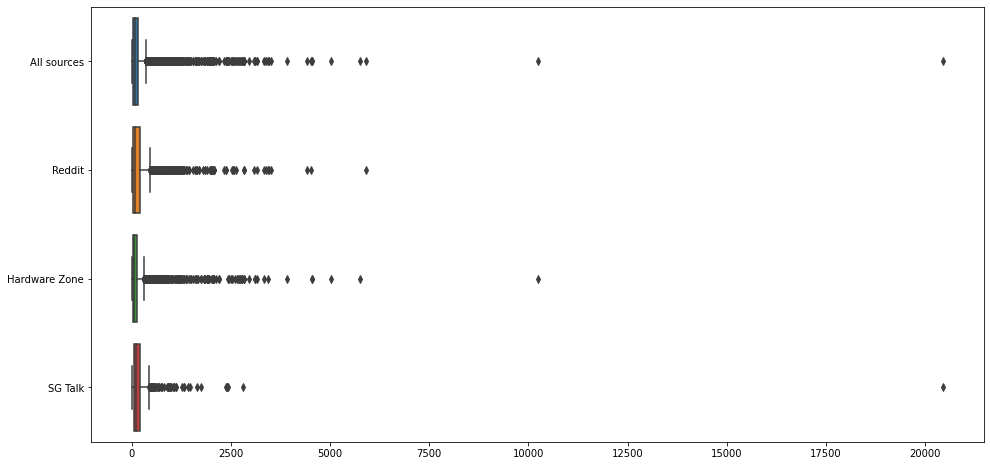

In [32]:
#plotting word count with outliers
plt.figure(figsize = (16,8))
sns.boxplot(data = [all_posts['word_count'], 
                    all_posts['word_count'][all_posts['source'] == 'reddit'],
                   all_posts['word_count'][all_posts['source'] == 'hardwarezone'],
                   all_posts['word_count'][all_posts['source'] == 'sgtalk']]
            , orient = 'h')
plt.yticks(np.arange(4), ('All sources', 'Reddit', 'Hardware Zone', 'SG Talk'));

In [33]:
#remove outlier posts of more than 5000 words 
display(all_posts[all_posts['word_count'] >=5000])

,post,date,source,post_clean,word_count
5086,The purpose of starting this thread is to cons...,2020-04-18 17:08:00,hardwarezone,purpose starting thread consolidate informatio...,5014
5300,The Big Read: Solving Singapore’s foreign work...,2020-11-05 10:51:00,sgtalk,big read solving singapore problem requires se...,20452
5908,Weighing Singapore's response to the Covid-19 ...,2020-04-22 10:23:00,hardwarezone,weighing singapore response pandemicdid singap...,10236
8678,Cut back on the back-patting: Singapores co...,2020-10-04 22:49:00,hardwarezone,cut back back patting singapore response loses...,5747
10173,I shall reproduce Ben Leong's full post below ...,2020-05-25 12:41:22,reddit,shall reproduce ben leong full post reading co...,5909


In [34]:
all_posts.drop([5086,5300, 5908, 8678, 10173], inplace=True)
all_posts.reset_index(drop=True)
display(all_posts[all_posts['word_count'] >=5000])

,post,date,source,post_clean,word_count


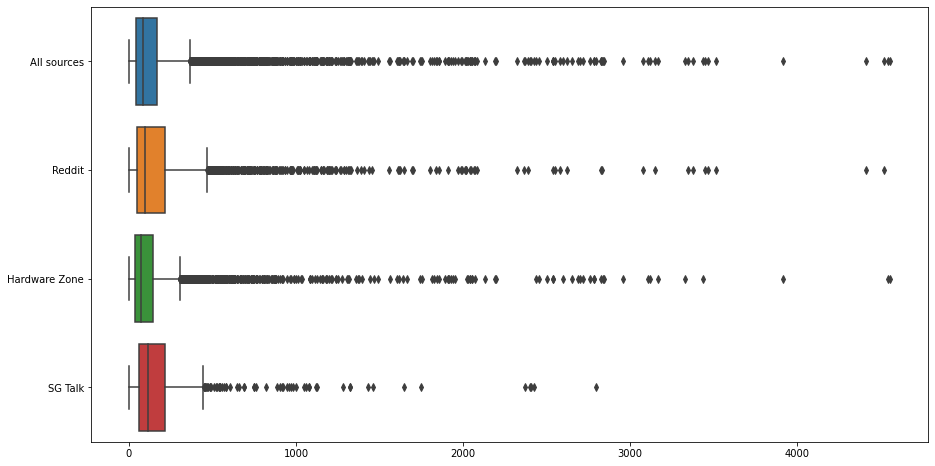

In [35]:
#plotting word count without outliers
plt.figure(figsize = (15,8))
sns.boxplot(data = [all_posts['word_count'], 
                    all_posts['word_count'][all_posts['source'] == 'reddit'],
                   all_posts['word_count'][all_posts['source'] == 'hardwarezone'],
                   all_posts['word_count'][all_posts['source'] == 'sgtalk']]
            , orient = 'h')
plt.yticks(np.arange(4), ('All sources', 'Reddit', 'Hardware Zone', 'SG Talk'));

#### Distribution of words by time

Plot shows posts written between January and December 2020. This cannot be correct as the outbreak in dorms only started in April 2020, which would be the correct start date for the posts, and the posts should end when data was scraped on 5 July 2020. An investigation into the posts written before and after April and July 2020 respectively showed that they were likely misdated on the website, and are talking about the COVID-19 outbreak in foreign worker dorms. These posts will be kept.

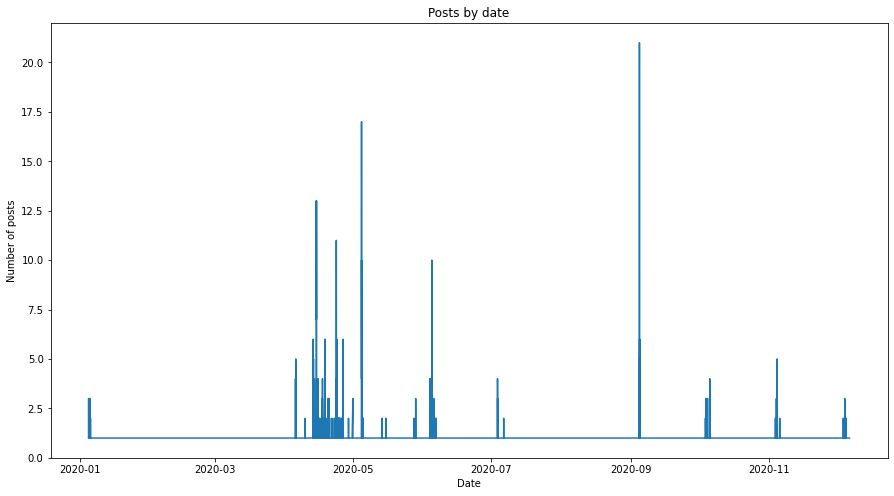

In [36]:
# plot shows that posts were written between Jan 2020 and Dec 2020, when data should reflect 
# Will remove posts before March 2020, when cases started appearing in dorms
# However, will keep posts with incorrect dates - posted after July 2020 as they are likely imputing errors
plt.figure(figsize = (15,8))
plt.plot(all_posts.groupby('date')['post'].count())
plt.title('Posts by date')
plt.xlabel('Date')
plt.ylabel('Number of posts');

In [39]:
all_posts[all_posts['date'] <'2020-03-01']

,post,date,source,post_clean,word_count
55,Most are from Dorm.I hope the authorities gave...,2020-01-05 18:51:00,sgtalk,hope authorities gave us 2 sets reports one ou...,72
74,need more cruise ship...maybe bankrupt Hin Leo...,2020-01-05 15:34:00,sgtalk,need cruise ship maybe bankrupt hin leong 100 ...,51
102,"give sinkies 600give FW 6,000jin satki maxanyo...",2020-01-05 09:34:00,hardwarezone,give sinkies 600give 6 000jin satki maxanyone ...,84
173,the food ok for them or not?,2020-01-05 12:26:00,hardwarezone,food ok not,11
215,Sigh... other countries are using hotels to qu...,2020-01-05 06:38:00,hardwarezone,sigh countries using hotels quarantine mild po...,1666
247,is this being used as a public cover to funnel...,2020-01-05 19:28:00,hardwarezone,used public cover funnel tax payer funds priva...,89
272,"Just abit concerned, how do we know what happe...",2020-01-05 12:54:00,hardwarezone,abit concerned know happened diamond princess ...,127
300,Last time this was their fav location on weeke...,2020-01-05 19:30:00,hardwarezone,last time fav location weekend sent using,41
329,At least no one can say we din treat FW well,2020-01-05 00:14:00,hardwarezone,least no one say din treat well,31
344,Wtf...all these payouts to foreigners. Who's p...,2020-01-05 07:43:00,hardwarezone,wtf payouts foreigners paying people singapore...,129


In [40]:
all_posts[all_posts['date'] > '2020-07-05']

,post,date,source,post_clean,word_count
2,Think Jo can move grc to helm jalan besar?,2020-09-04 20:25:00,hardwarezone,think jo move grc helm jalan besar,34
28,Who are their employer?Gahmen ?The Sentosa cov...,2020-12-05 08:01:00,sgtalk,employer gahmen sentosa cove auntie happy,41
39,heart condition is linked to covid19. how can ...,2020-10-04 18:48:00,hardwarezone,heart condition linked covid19 brush like many...,65
48,is there any way to know all the cluster count...,2020-09-04 22:31:00,hardwarezone,way know cluster count till date,32
51,Where ramen or rabbit1,2020-09-04 20:10:00,hardwarezone,ramen rabbit1,13
54,"Yes, cannot guniang guniang,must be firm like ...",2020-09-04 21:23:00,hardwarezone,yes cannot guniang guniang must firm like russ...,200
66,Wtf dont anyhow leh,2020-09-04 19:59:00,hardwarezone,wtf anyhow leh,14
70,Fantastic ...,2020-11-05 21:33:00,sgtalk,fantastic,9
87,Poor opposition........no avenue to do 'rally...,2020-11-06 21:23:00,sgtalk,poor opposition no avenue rally speech erectio...,105
89,Lol more than what I think if it's true. I onl...,2020-09-04 19:56:00,hardwarezone,lol think true guess 200,24


#### Top words for each source

In [41]:
def plots(series, source):
    
    cvec = CountVectorizer(stop_words = 'english', ngram_range=(1,2))
    cvec.fit_transform(series)
    series_df = pd.DataFrame(cvec.fit_transform(series).toarray(), 
                             columns=cvec.get_feature_names())
    wordcount_df = pd.DataFrame(series_df.sum().sort_values(ascending=False).head(50), 
                                  columns=['count'])
    
    #barplot 
    plt.figure(figsize = (12,8))
    sns.barplot(y = wordcount_df.index, x = 'count', data = wordcount_df, 
                palette = 'magma')
    plt.title(f'Top 50 words used in {source}', fontsize= 18)
    plt.xlabel('Word Count', fontsize = 14)
    plt.ylabel('Words',fontsize = 14)
    
    #wordcloud
    wc = WordCloud(max_words=100, background_color="white", 
                   colormap = 'magma').generate(series.to_string())
    plt.figure(figsize = (10,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Top words used in {source}', fontsize= 18)

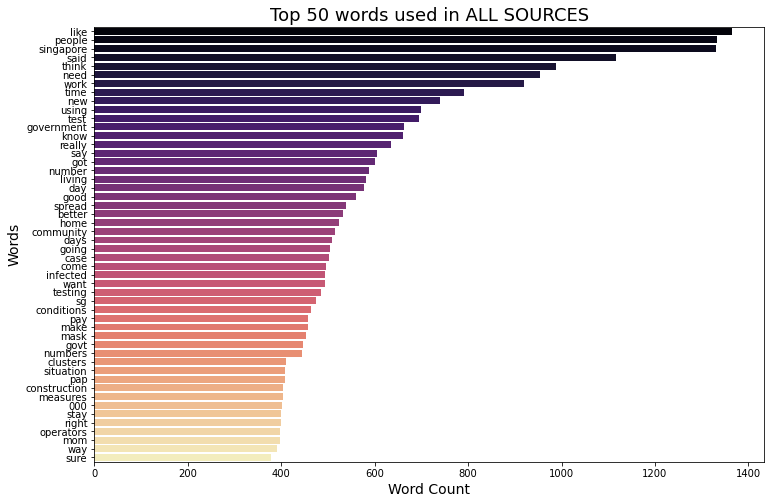

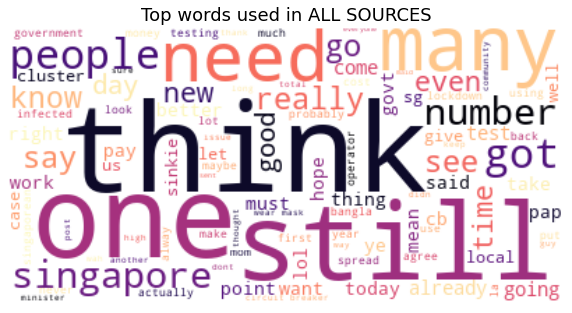

In [42]:
plots(all_posts['post_clean'], 'ALL SOURCES')

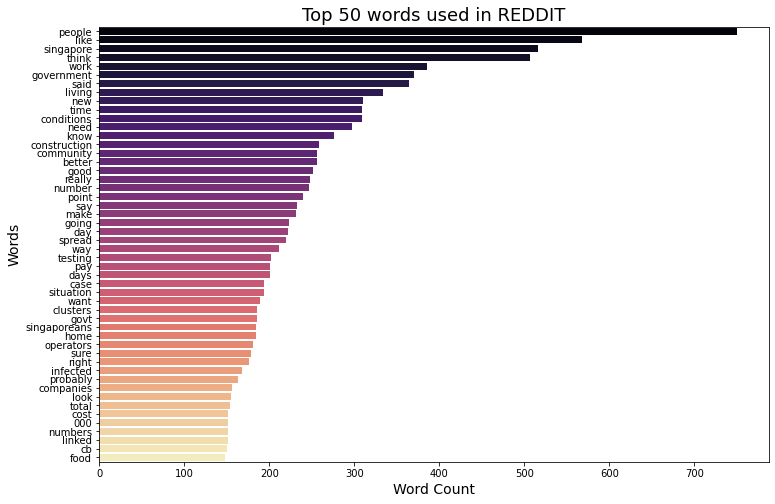

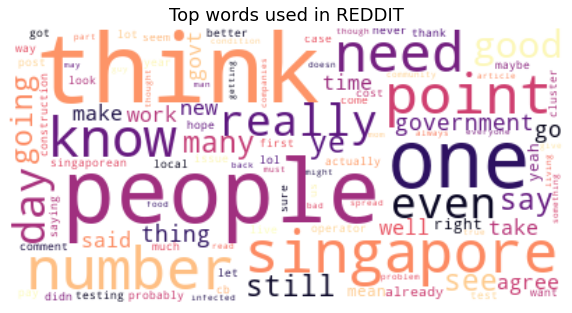

In [43]:
plots(all_posts['post_clean'][all_posts['source']=='reddit'], 'REDDIT')

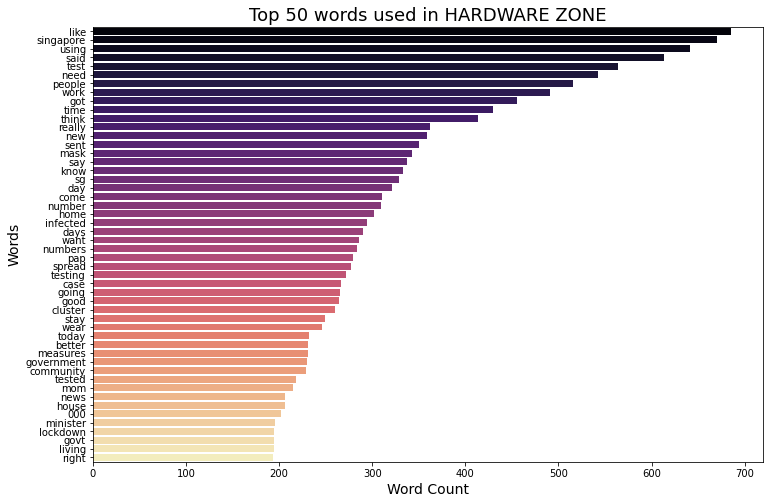

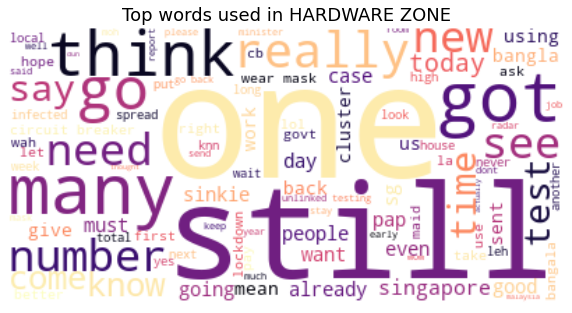

In [44]:
plots(all_posts['post_clean'][all_posts['source']=='hardwarezone'], 'HARDWARE ZONE')

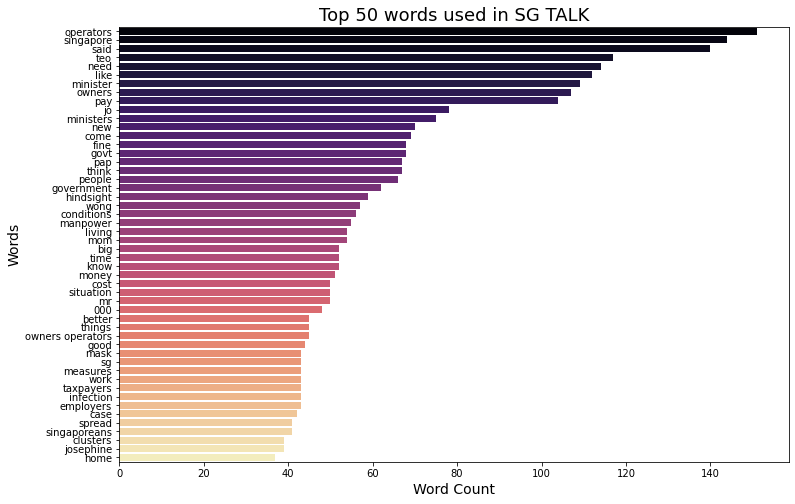

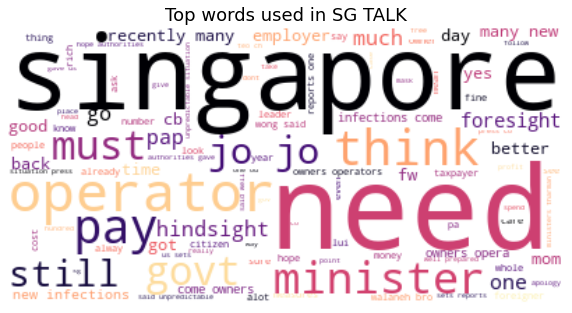

In [45]:
plots(all_posts['post_clean'][all_posts['source']=='sgtalk'], 'SG TALK')

#### Top bigrams for each source

In [46]:
def bigram_plots(series, source):
    
    cvec = CountVectorizer(stop_words = 'english', ngram_range=(2,3))
    cvec.fit_transform(series)
    series_df = pd.DataFrame(cvec.fit_transform(series).toarray(), 
                             columns=cvec.get_feature_names())
    wordcount_df = pd.DataFrame(series_df.sum().sort_values(ascending=False).head(50), 
                                  columns=['count'])
    
    #barplot 
    plt.figure(figsize = (12,8))
    sns.barplot(y = wordcount_df.index, x = 'count', data = wordcount_df, 
                palette = 'viridis')
    plt.title(f'Top 50 bigrams used in {source}', fontsize= 18)
    plt.xlabel('Word Count', fontsize = 14)
    plt.ylabel('Words',fontsize = 14)
    
    #wordcloud
    wc = WordCloud(max_words=100, background_color="white", 
                   colormap = 'viridis').generate(series.to_string())
    plt.figure(figsize = (10,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Top bigrams used in {source}', fontsize= 18)

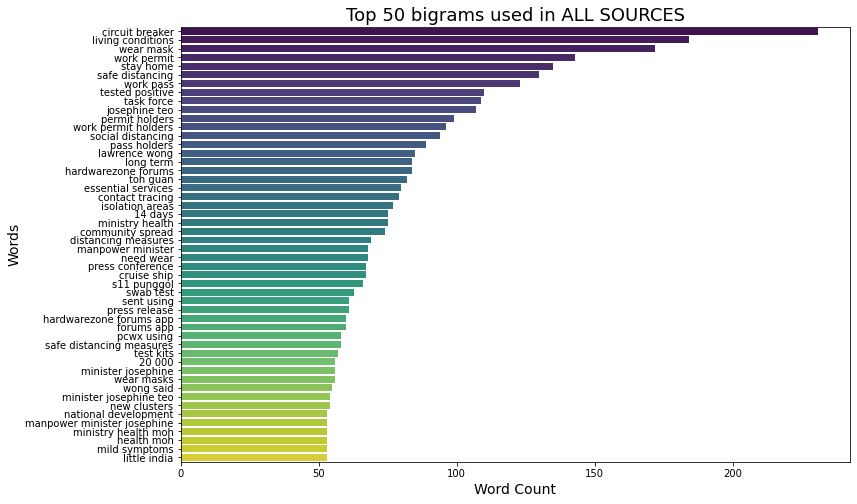

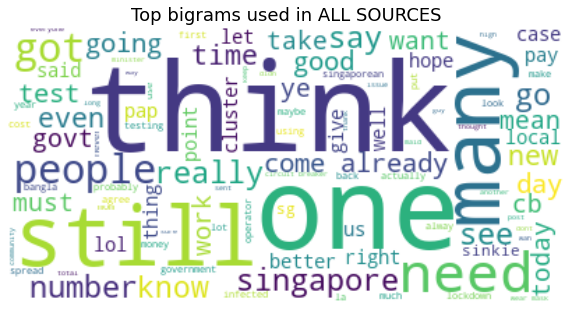

In [47]:
bigram_plots(all_posts['post_clean'], 'ALL SOURCES')

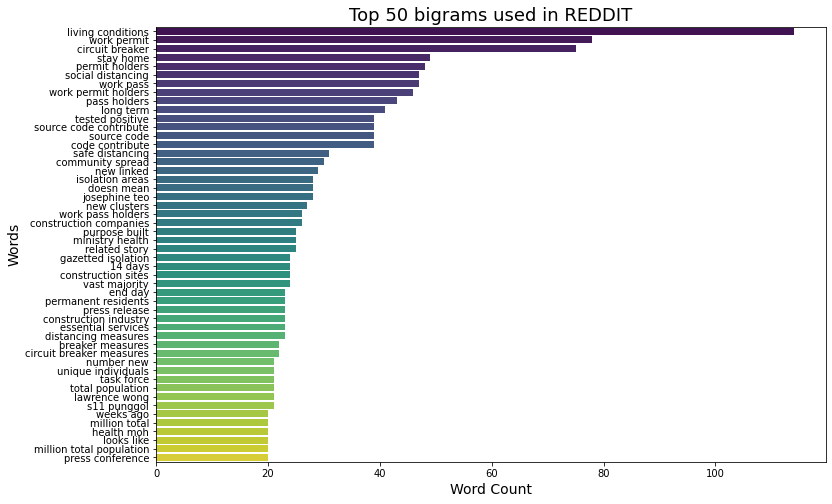

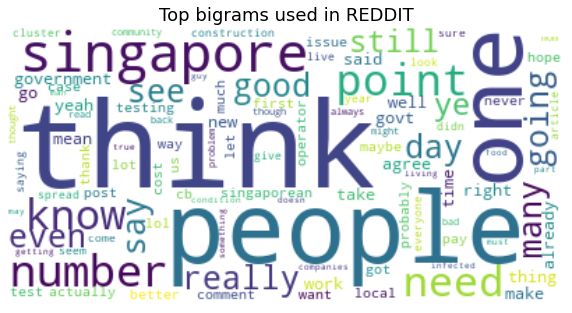

In [48]:
bigram_plots(all_posts['post_clean'][all_posts['source']=='reddit'], 'REDDIT')

/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25105 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/dorafoong/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/dorafoong/opt/anaconda3/lib/python3.7/

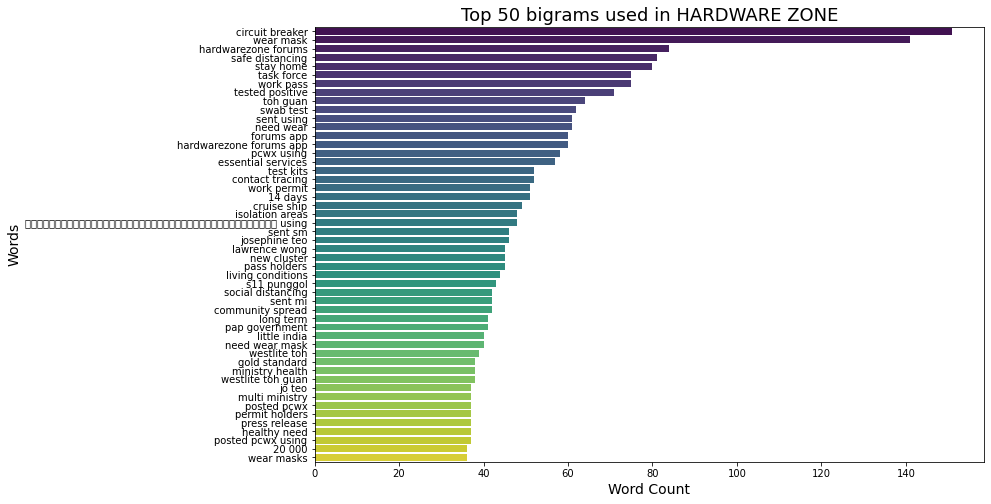

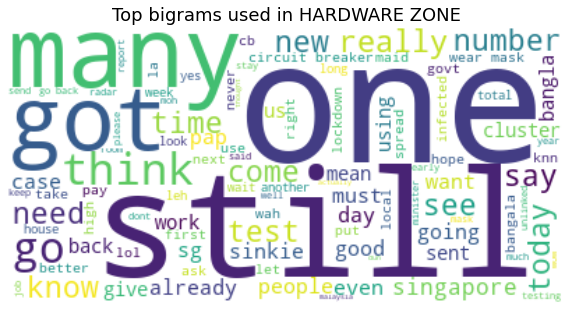

In [49]:
bigram_plots(all_posts['post_clean'][all_posts['source']=='hardwarezone'], 'HARDWARE ZONE')

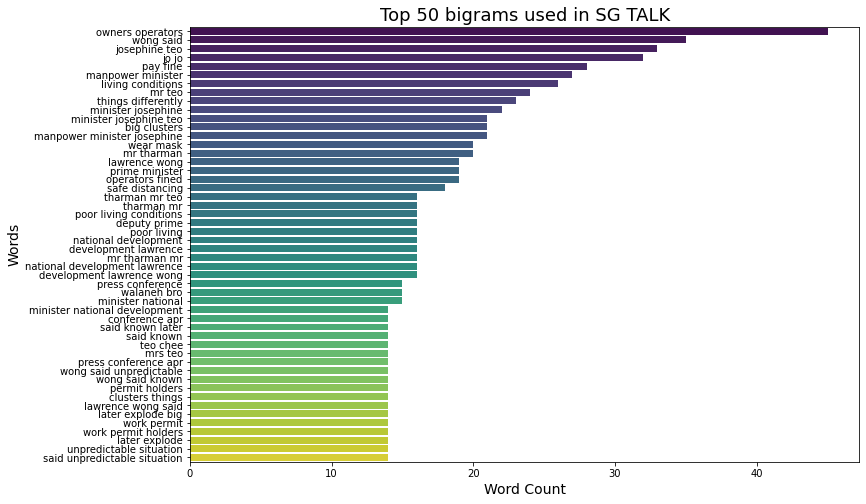

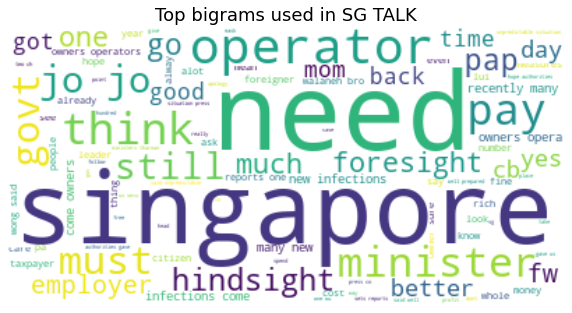

In [50]:
bigram_plots(all_posts['post_clean'][all_posts['source']=='sgtalk'], 'SG TALK')

### Export ```all_words```

In [51]:
all_posts.to_csv("./all_posts.csv", index=False)